# Electricity Tariff in Norway

The monthly electricity cost has three terms:
- A time-of-use cost with time-varying prices. These
vary over the day depending on on-peak/off-peak hours and seasonally.
- A real-time cost with time-varying prices given by NordPool. Prices are announced veryday at 4pm for the day ahead.
- A peak power cost, which is a staircase function of the monthly average of the three highest hourly powers on different days.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from utils import *

## Time-of-use prices

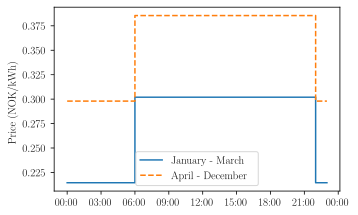

In [12]:
def create_monthly_price_data(year, month, peak_price, off_peak_price):
    date_range = pd.date_range(start=f'{year}-{month:02d}-01', periods=pd.Timestamp(year, month, 1).days_in_month * 24, freq='H')
    prices = [off_peak_price if (hour < 6 or hour >= 22) else peak_price for hour in date_range.hour]
    return pd.Series(prices, index=date_range)

def get_peak_and_off_peak_prices(month):
    return (0.3020, 0.2145) if month in [1, 2, 3] else (0.3855, 0.2980)

price_data = pd.concat([
    create_monthly_price_data(year, month, *get_peak_and_off_peak_prices(month))
    for year in range(2020, 2024)
    for month in range(1, 13)
])

pd.to_pickle(price_data, "data/tou_price_data.pickle")

# Plot time-of-use tariff
latexify(fig_width=5)
fig, ax = plt.subplots()
jan_data = price_data.loc['2020-01-01':'2020-01-01']
jun_data = price_data.loc['2020-06-01':'2020-06-01']
ax.step(jan_data.index, jan_data.values, where='post', color="tab:blue", linestyle="solid", label='January - March')
ax.step(jan_data.index, jun_data.values, where='post', color="tab:orange", linestyle="dashed", label='April - December')
ax.set_ylabel("Price (NOK/kWh)")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.grid(True)
plt.tight_layout()

plt.savefig("figures/tou_tariff.pdf")

## Peak power cost

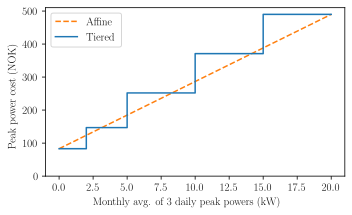

In [10]:
# Define parameters
peak_power_staircase = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_cost_staircase = [83, 147, 252, 371, 490]

peak_power_values = np.linspace(0, 20, 500)

# Compute peak cost for tiered peak pricing
peak_price_values, peak_cost_tiered = [], []
for (x_min, x_max), price in zip(peak_power_staircase, peak_cost_staircase):
    x_range = np.linspace(x_min, x_max, 100)
    peak_price_values.extend(x_range)
    peak_cost_tiered.extend([price] * len(x_range))

# Compute cost for affine pricing
def affine_cost(x):
    return 20.35 * x + 83

peak_cost_affine = [affine_cost(x) for x in peak_price_values]

# Create plot
latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(peak_price_values, peak_cost_affine, label='Affine', color="tab:orange", linestyle='dashed')
ax.plot(peak_price_values, peak_cost_tiered, label='Tiered', color="tab:blue", linestyle='solid')
ax.set_xlabel("Monthly avg. of 3 daily peak powers (kW)")
ax.set_ylabel("Peak power cost (NOK)")
ax.set_ylim(0)
# ax.grid(True)
ax.legend()
plt.tight_layout()

plt.savefig("figures/peak_power_tariff.pdf")